In [1]:
 import numpy as np
 import matplotlib.pyplot as plt
 import pandas as pd
 import seaborn as sns
 import re

In [2]:
data_heart = pd.read_csv('../Datasets/heart_2022_cleaned.csv')
data_heart.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


### Phân phối các đặc trưng phân loại về bệnh mãn tính

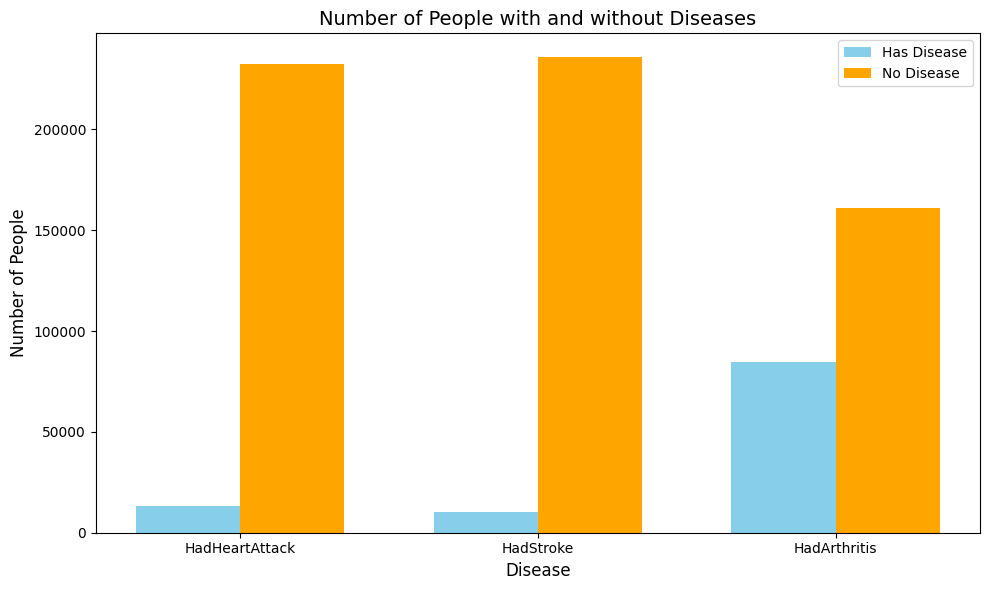

In [3]:
# Danh sách các bệnh
diseases = ['HadHeartAttack', 'HadStroke', 'HadArthritis']

#Chuyển kiểu dữ liệu cột HadHeartAttack, HadStroke, HadArthritis sang kiểu int
data_heart['HadHeartAttack'] = data_heart['HadHeartAttack'].apply(lambda x: 1 if x == 'Yes' else 0)
data_heart['HadStroke'] = data_heart['HadStroke'].apply(lambda x: 1 if x == 'Yes' else 0)
data_heart['HadArthritis'] = data_heart['HadArthritis'].apply(lambda x: 1 if x == 'Yes' else 0)

# Tính số lượng mắc (1) và không mắc (0) từng bệnh
disease_counts = pd.DataFrame({
    'Disease': diseases,
    'Has Disease': data_heart[diseases].sum(),
    'No Disease': data_heart[diseases].shape[0] - data_heart[diseases].sum()
})

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35  # Độ rộng của cột
index = range(len(diseases))  # Vị trí các cột

# Vẽ cột cho người mắc bệnh
ax.bar(index, disease_counts['Has Disease'], bar_width, label='Has Disease', color='skyblue')

# Vẽ cột cho người không mắc bệnh (đặt cạnh nhau)
ax.bar([i + bar_width for i in index], disease_counts['No Disease'], bar_width, label='No Disease', color='orange')

# Cài đặt nhãn và tiêu đề
ax.set_xlabel('Disease', fontsize=12)
ax.set_ylabel('Number of People', fontsize=12)
ax.set_title('Number of People with and without Diseases', fontsize=14)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(diseases, fontsize=10)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

### 2. Với những người thuộc nhóm AgeCategory từ 45 tuổi trở lên, tình trạng hút thuốc (SmokerStatus) và số giờ ngủ trung bình mỗi đêm (SleepHours) ảnh hưởng như thế nào đến tỷ lệ mắc các bệnh mãn tính như HadHeartAttack, HadStroke, và HadArthritis, khi xét thêm yếu tố chỉ số BMI (BMI) và số ngày sức khỏe thể chất không tốt (PhysicalHealthDays)?

#### 2.1 Các thông tin liên quan

##### 2.1.1 Chỉ số BMI

- BMI (Body Mass Index - Chỉ số khối cơ thể) là một chỉ số đo lường dựa trên cân nặng và chiều cao để đánh giá tình trạng cơ thể (thiếu cân, cân nặng bình thường, thừa cân, hoặc béo phì).
- Công thức tính:

    + BMI = Cân năng (Kg) / Chiều cao (m) ^ 2
​
 
- Phân loại BMI theo WHO:

    + Dưới 18.5: Thiếu cân
    + 18.5 - 24.9: Bình thường
    + 25.0 - 29.9: Thừa cân
    + ≥ 30.0: Béo phì

##### 2.1.2 Các bệnh mãn tính

- Nhồi máu cơ tim (HadHeartAttack):
    + Là tình trạng xảy ra khi dòng máu đến cơ tim bị giảm hoặc tắc nghẽn hoàn toàn, thường do cục máu đông hoặc xơ vữa động mạch.
    + Nguyên nhân chính: Hút thuốc, huyết áp cao, cholesterol cao, béo phì, lối sống ít vận động.
    + Triệu chứng: Đau thắt ngực, khó thở, buồn nôn, mệt mỏi.
- Đột quỵ (HadStroke):
    + Là tình trạng mất lưu thông máu đến một phần của não, gây tổn thương não nghiêm trọng.
    + Loại:
        * Thiếu máu não (ischemic stroke): Do tắc nghẽn mạch máu.
        * Xuất huyết não (hemorrhagic stroke): Do vỡ mạch máu não.
    + Nguyên nhân chính: Huyết áp cao, bệnh tim mạch, tiểu đường, hút thuốc, cholesterol cao.
    + Triệu chứng: Liệt mặt hoặc chân tay, khó nói, mất thăng bằng, nhức đầu nghiêm trọng.
- Viêm khớp (HadArthritis):
    + Là tình trạng viêm các khớp, gây đau, sưng, cứng và giảm vận động.
    + Loại phổ biến:
        * Viêm xương khớp (Osteoarthritis): Do thoái hóa khớp.
        * Viêm khớp dạng thấp (Rheumatoid arthritis): Bệnh tự miễn.
    + Nguyên nhân chính: Lão hóa, di truyền, béo phì, chấn thương khớp.
    + Triệu chứng: Đau khớp, cứng khớp, giảm khả năng vận động.

##### 2.1.3 Lý do chọn những người trên 45 tuổi

- Vì đây là độ tuổi mà các vấn đề sức khỏe, đặc biệt là các bệnh mãn tính (như bệnh tim, đột quỵ, viêm khớp), thường bắt đầu xuất hiện hoặc trở nên nghiêm trọng hơn. Một số lý do cụ thể như:
    + Nguy cơ bệnh mãn tính tăng theo độ tuổi: Khi con người già đi, các yếu tố như sự suy giảm hệ miễn dịch, tăng tích tụ mỡ trong cơ thể, sự thay đổi trong lối sống và hoạt động thể chất, đều có thể làm tăng nguy cơ mắc các bệnh như tim mạch, đột quỵ, và viêm khớp.
    + Ảnh hưởng của lối sống: Những thói quen xấu (như hút thuốc, thiếu ngủ) thường tích tụ qua thời gian và bắt đầu gây ảnh hưởng lớn hơn đến sức khỏe ở lứa tuổi trung niên (45 tuổi trở lên).
    + Chăm sóc sức khỏe và can thiệp sớm: Ở độ tuổi này, nhiều người bắt đầu đi kiểm tra sức khỏe định kỳ, và các bệnh tiềm ẩn có thể được phát hiện sớm hơn, vì vậy việc phân tích ở nhóm này sẽ cung cấp cái nhìn thực tế về tình trạng sức khỏe và các yếu tố nguy cơ

#### 2.2 Ý nghĩa của việc trả lời câu hỏi này

- Câu hỏi này giúp khám phá và hiểu rõ hơn mối quan hệ giữa các yếu tố lối sống (như hút thuốc, giấc ngủ) và sức khỏe thể chất (thể hiện qua BMI, số ngày sức khỏe không tốt) đối với tỷ lệ mắc các bệnh mãn tính (như bệnh tim, đột quỵ, viêm khớp) ở những người 45 tuổi trở lên. Việc phân tích dữ liệu này có thể mang lại những hiểu biết quan trọng về cách các yếu tố này tương tác với nhau và ảnh hưởng đến sức khỏe tổng thể của người lớn tuổi, đặc biệt trong việc phát hiện các yếu tố nguy cơ có thể kiểm soát được
=> Qua đó giúp đưa ra các chiến lược can thiệp sức khỏe phù hợp và hiệu quả hơn để cải thiện chất lượng cuộc sống của họ.

#### 2.3 Phân tích hướng xử lí

Phạm vi dữ liệu: Chỉ chọn những người thuộc nhóm AgeCategory từ 45 tuổi trở lên.

Phân tích:
- Nhóm theo SmokerStatus (chia thành 3 nhóm: người chưa từng hút thuốc, người đã từng hút thuốc và người hiện tại vẫn đang hút thuốc) và SleepHours (chia thành các nhóm ngắn ngủ dưới 6 giờ, trung bình từ 6-8 giờ, và ngủ dài trên 8 giờ).
- So sánh tỷ lệ mắc HadHeartAttack, HadStroke, và HadArthritis giữa các nhóm.
- Kết hợp thêm yếu tố BMI (phân nhóm dưới 25, 25-30, trên 30) và số ngày sức khỏe thể chất không tốt (PhysicalHealthDays) để tìm hiểu sự khác biệt rõ rệt hơn.*

Kết quả kỳ vọng:
Xác định liệu có sự tương tác giữa các yếu tố lối sống (ngủ, hút thuốc) và bệnh mãn tính, đặc biệt khi có các yếu tố rủi ro khác như BMI cao và sức khỏe thể chất kém.

#### 2.4 Tiền xử lý

In [4]:
data_Q1 = data_heart[['AgeCategory', 'SleepHours', 'SmokerStatus', 'BMI', 'PhysicalHealthDays', 'HadHeartAttack', 'HadStroke', 'HadArthritis']].copy()

#Lọc ra người có tuổi từ 45 trở lên
data_Q1['AgeCategory'] = data_Q1['AgeCategory'].apply(lambda x: int(x.split(' ')[1]))
data_Q1 = data_Q1[data_Q1['AgeCategory'] >= 45].reset_index(drop=True)

#Phân nhóm dựa theo việc hút thuốc
data_Q1['SmokerStatus'] = data_Q1['SmokerStatus'].apply(lambda x: x.split(' ')[0])
data_Q1.loc[data_Q1['SmokerStatus'] == 'Never', 'SmokerStatus'] = 'Never Smoker'
data_Q1.loc[data_Q1['SmokerStatus'] == 'Former', 'SmokerStatus'] = 'Former Smoker'
data_Q1.loc[data_Q1['SmokerStatus'] == 'Current', 'SmokerStatus'] = 'Current Smoker'

# Phân nhóm giấc ngủ (SleepHours)
sleep_labels = ['< 6 hours', '6-8 hours', '> 8 hours']
sleep_bins = [0, 6, 8, float('inf')]  # Define bin edges
data_Q1['SleepHoursGroup'] = pd.cut(data_Q1['SleepHours'], bins=sleep_bins, labels=sleep_labels, right=False)

# Phân nhóm BMI
bmi_labels = ['Thin', 'Normal', 'Overweight', 'Obese']
bmi_bins = [0, 18.5, 25, 30, float('inf')]  # Define bin edges
data_Q1['BMICategory'] = pd.cut(data_Q1['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

def plot_combined(data, name, health):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # heatmap
    pivot = data.pivot_table(values=health, index='BMICategory', columns=name, aggfunc='mean', observed=False)
    sns.heatmap(pivot, annot=False, fmt='.0f', cmap='YlGnBu', ax=axes[0], cbar_kws={'label': 'Heart Attack Rate'})
    axes[0].set_title(f'{health} by {name} and BMI')
    axes[0].set_xlabel('Physical Health Days')
    axes[0].set_ylabel(name)
    
    # barplot
    sns.barplot(data=data, x='BMICategory', y=health, hue=name, palette='coolwarm', ax=axes[1])
    axes[1].set_title(f'Mean {health} by {name} and BMI')
    axes[1].set_xlabel('BMI')
    axes[1].set_ylabel(health)

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()


In [5]:
data_Q1.sample(5)

,AgeCategory,SleepHours,SmokerStatus,BMI,PhysicalHealthDays,HadHeartAttack,HadStroke,HadArthritis,SleepHoursGroup,BMICategory
108711,75,8.0,Former Smoker,23.63,0.0,0,0,0,> 8 hours,Normal
501,60,8.0,Never Smoker,24.11,0.0,0,0,0,> 8 hours,Normal
19061,45,8.0,Never Smoker,25.02,0.0,0,0,1,> 8 hours,Overweight
133369,70,9.0,Never Smoker,31.46,30.0,0,0,1,> 8 hours,Obese
10958,50,7.0,Never Smoker,31.87,2.0,0,0,0,6-8 hours,Obese


#### 2.5 Phân tích để trả lời câu hỏi

##### 2.5.1 So sánh tỷ lệ mắc bệnh mãn tính và số ngày sức khỏe thể chất không tốt theo các nhóm của tình trạng hút thuốc

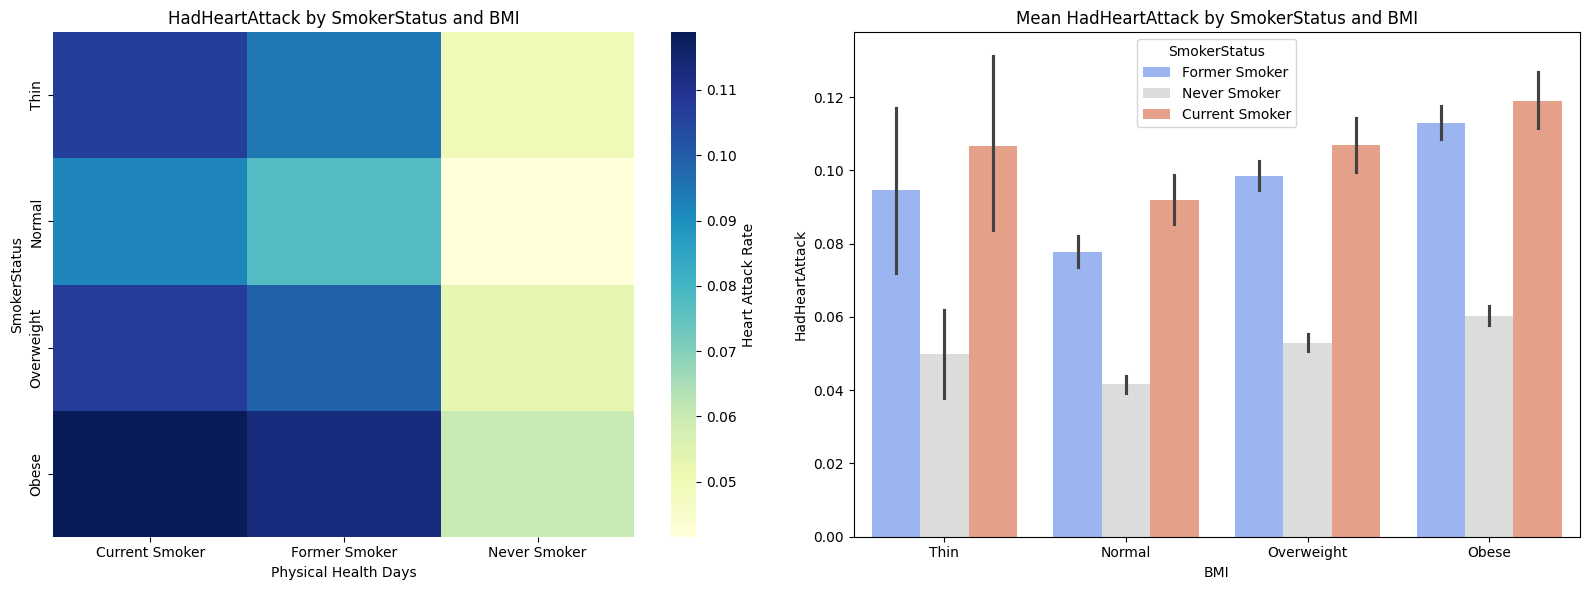

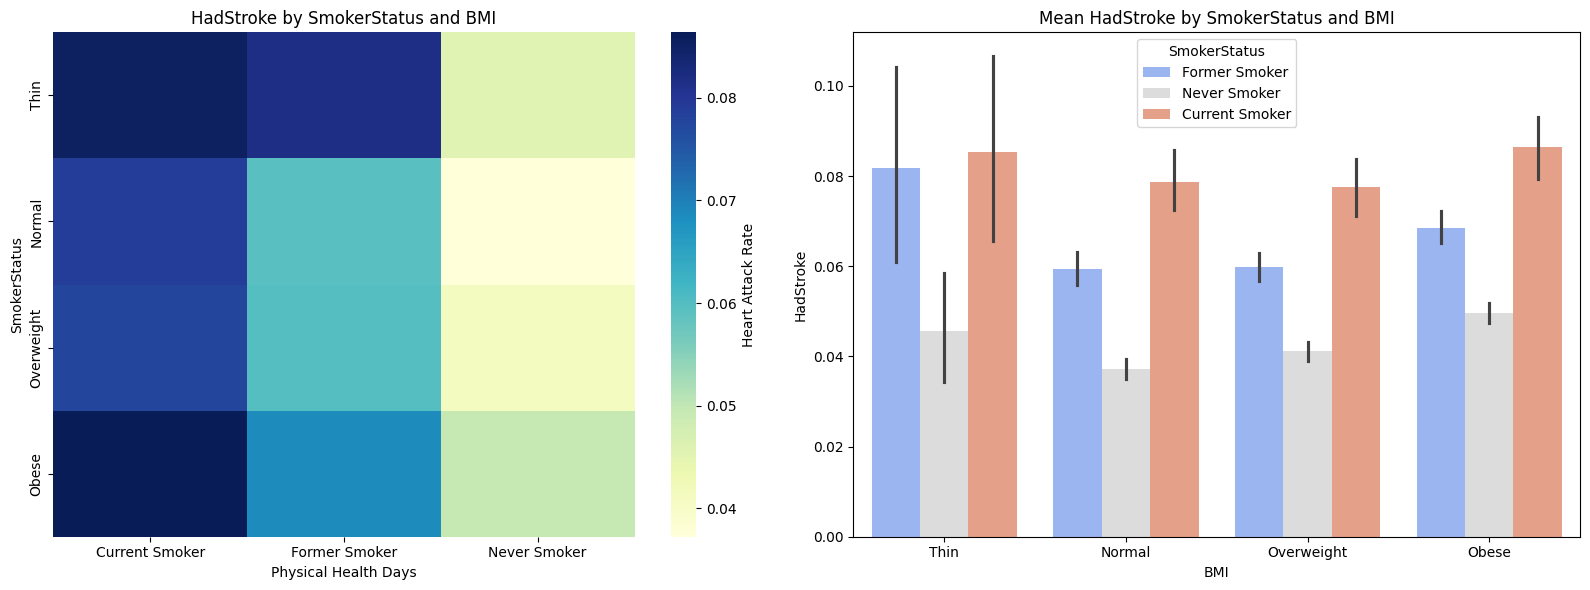

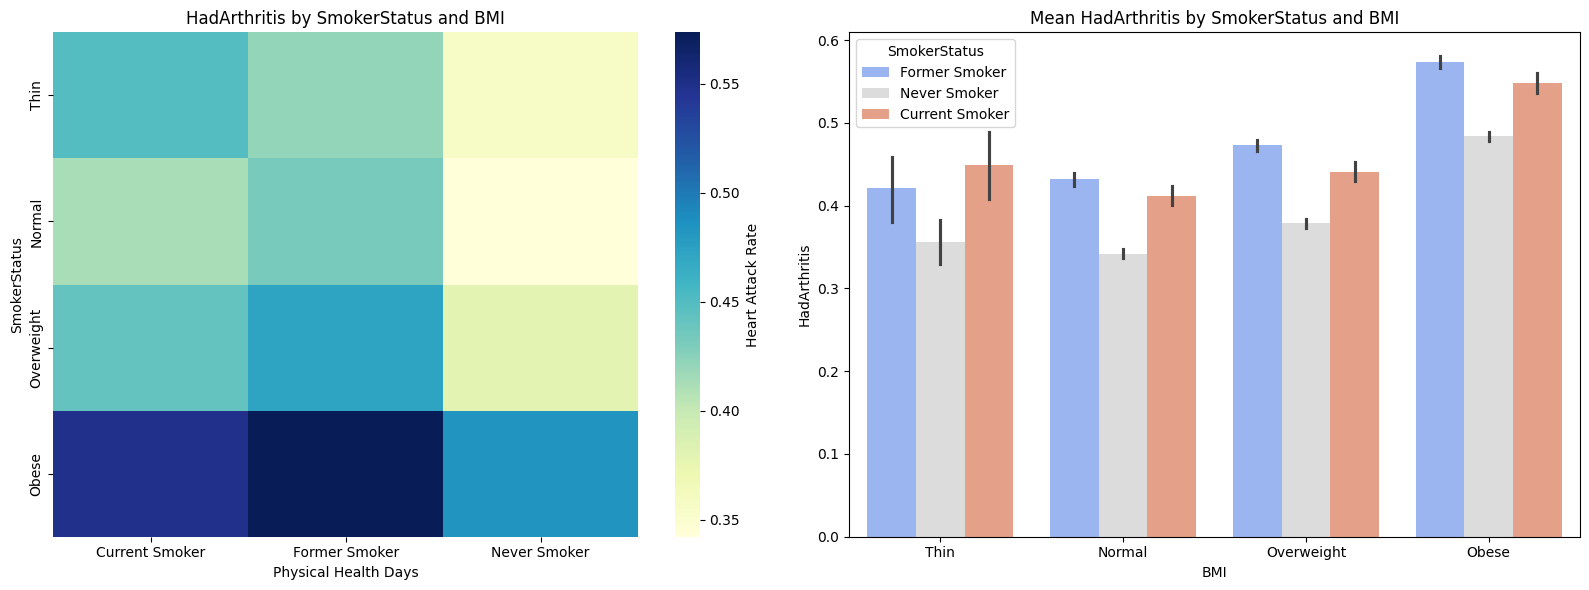

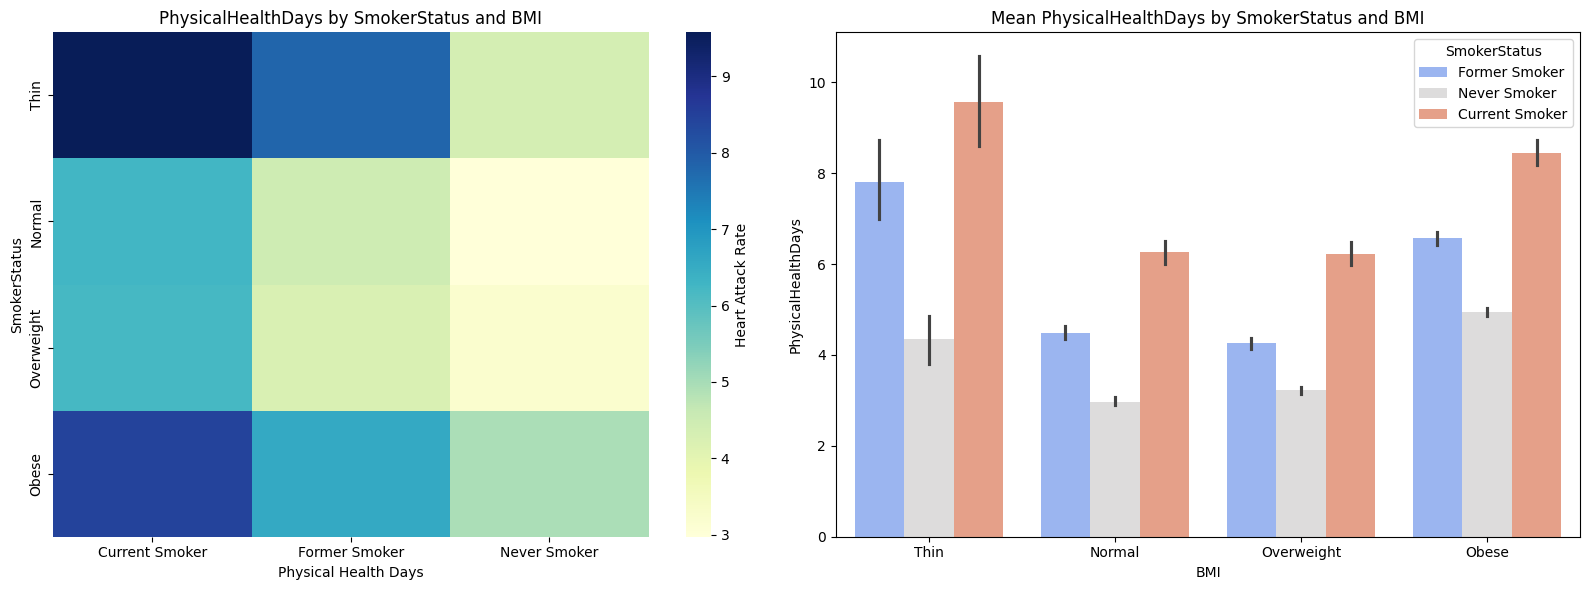

In [6]:
plot_combined(data_Q1, 'SmokerStatus', 'HadHeartAttack')
plot_combined(data_Q1, 'SmokerStatus', 'HadStroke')
plot_combined(data_Q1, 'SmokerStatus', 'HadArthritis')
plot_combined(data_Q1, 'SmokerStatus', 'PhysicalHealthDays')

Từ biểu đồ chúng ta có thể thấy:
- Ảnh hưởng của việc hút thuốc đối với sức khỏe:
    + Các nhóm người hút thuốc (bao gồm cả nhóm đã từng hút thuốc) có số ngày sức khỏe không tốt cao hơn và tỷ lệ mắc bệnh mãn tính (như bệnh tim, đột quỵ, viêm khớp) cũng cao hơn. Điều này phản ánh tác động tiêu cực của thuốc lá đối với sức khỏe, đặc biệt đối với các vấn đề liên quan đến tim mạch và hệ thần kinh.
    + Tuy nhiên, nhóm người gầy có tỷ lệ mắc bệnh tim và đột quỵ thấp hơn so với nhóm người béo phì, điều này có thể chỉ ra rằng tình trạng cân nặng ảnh hưởng đến sức khỏe người hút thuốc.
- So sánh giữa nhóm người hút thuốc và nhóm đã từng hút thuốc:
    + Nhóm đã từng hút thuốc có tỷ lệ mắc viêm khớp cao hơn so với nhóm người đang hút thuốc (ngoại trừ nhóm người gầy). Điều này có thể do các yếu tố khác liên quan đến thời gian ngừng hút thuốc hoặc di chứng lâu dài của việc hút thuốc trước đây.
    + Tuy nhiên, tỷ lệ mắc bệnh tim và đột quỵ lại thấp hơn ở nhóm người đã từng hút thuốc so với nhóm người hiện tại đang hút thuốc, cho thấy có thể có sự cải thiện sức khỏe ở nhóm đã ngừng hút thuốc.
- Sự khác biệt giữa nhóm không hút thuốc và nhóm hút thuốc:
    + Nhóm không hút thuốc có số ngày sức khỏe không tốt thấp nhất và tỷ lệ mắc các bệnh mãn tính như bệnh tim và đột quỵ thấp hơn rõ rệt so với hai nhóm còn lại. Điều này chỉ ra rằng không hút thuốc là yếu tố bảo vệ sức khỏe quan trọng.
    + Tuy nhiên, tỷ lệ mắc viêm khớp ở nhóm không hút thuốc không thấp hơn quá nhiều so với các nhóm hút thuốc, cho thấy yếu tố khác ngoài hút thuốc có thể ảnh hưởng đến bệnh này (ví dụ: tuổi tác, yếu tố di truyền, thói quen sinh hoạt).


##### 2.5.2 So sánh tỷ lệ mắc bệnh mãn tính và số ngày sức khỏe thể chất không tốt theo các nhóm của số giờ ngủ

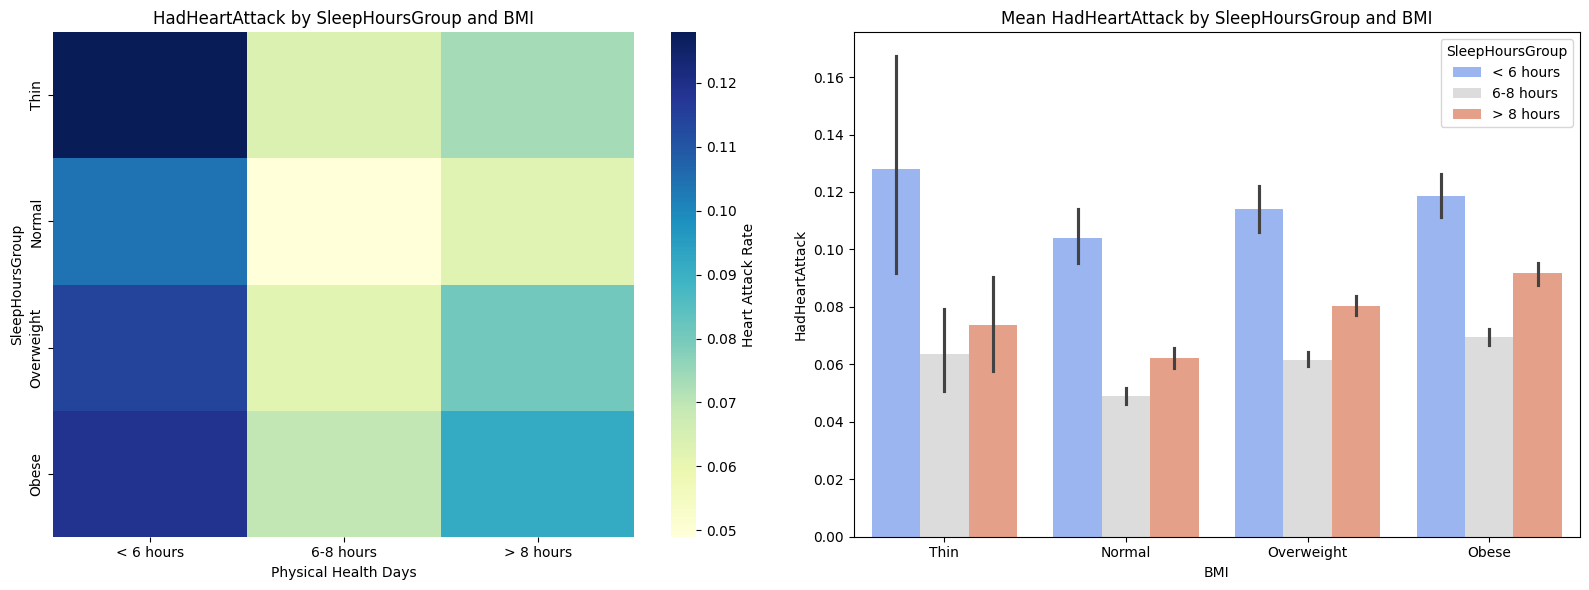

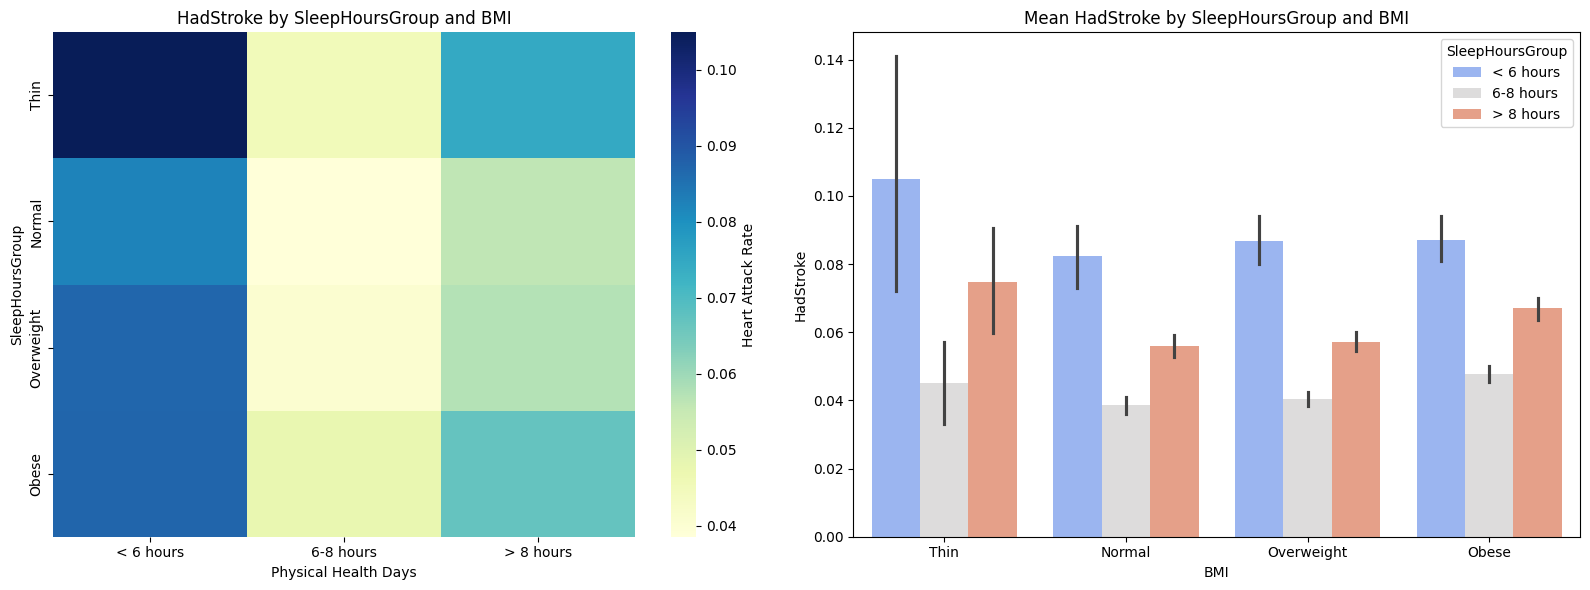

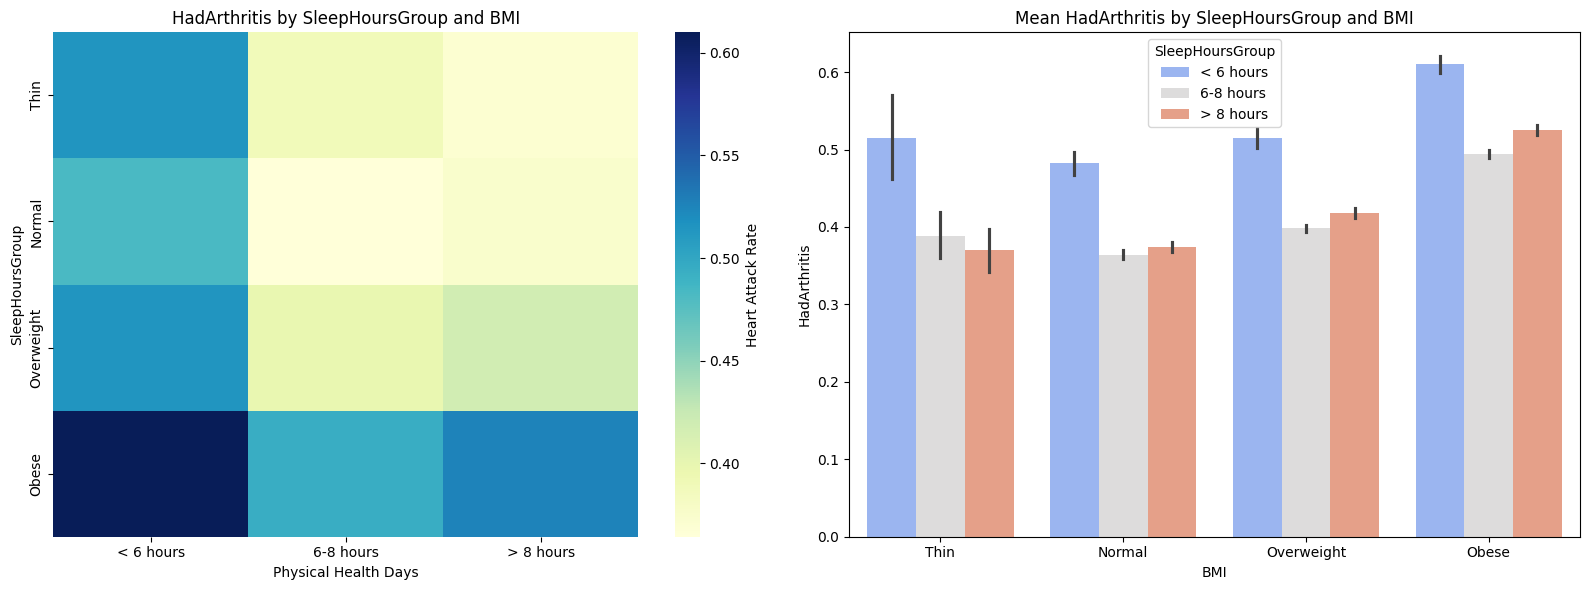

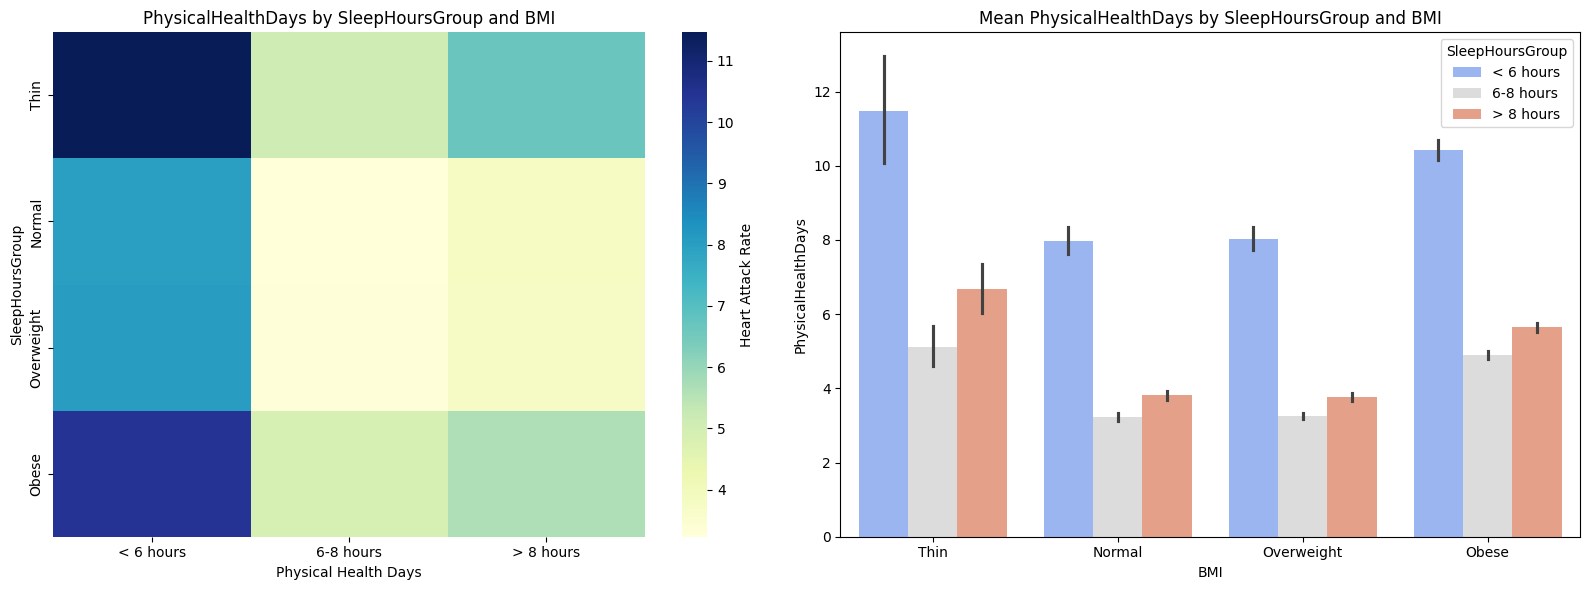

In [7]:
plot_combined(data_Q1, 'SleepHoursGroup', 'HadHeartAttack')
plot_combined(data_Q1, 'SleepHoursGroup', 'HadStroke')
plot_combined(data_Q1, 'SleepHoursGroup', 'HadArthritis')
plot_combined(data_Q1, 'SleepHoursGroup', 'PhysicalHealthDays')

Từ biểu đồ chúng ta có thể thấy:
- Ngủ ít hơn 6 giờ: Số ngày sức khỏe không tốt (PhysicalHealthDays) và tỷ lệ mắc các bệnh mãn tính ở nhóm này rất cao. Điều này cho thấy thiếu ngủ nghiêm trọng có thể gây ra các vấn đề về sức khỏe, ảnh hưởng đến khả năng phục hồi và tăng nguy cơ mắc bệnh mãn tính.
Sự khác biệt giữa các nhóm giấc ngủ:
- Tỷ lệ mắc bệnh mãn tính giữa các nhóm người ngủ ít hơn 6 giờ không có sự chênh lệch quá lớn, nhưng số ngày sức khỏe vật lý lại có sự khác biệt rõ rệt, đặc biệt ở nhóm người gầy và béo phì. Điều này có thể chỉ ra rằng, dù thời gian ngủ ngắn, nhưng tình trạng sức khỏe thể chất của họ có thể bị ảnh hưởng mạnh mẽ bởi các yếu tố như cân nặng hoặc tình trạng sức khỏe tổng thể.
- Nhóm béo phì có tỷ lệ mắc bệnh viêm khớp cao hơn các nhóm còn lại. Đây có thể là do khối lượng cơ thể lớn gây áp lực lên khớp xương, dẫn đến các vấn đề về viêm khớp, đặc biệt là khi không có giấc ngủ đầy đủ hoặc giấc ngủ không đủ chất lượng.
- Nhóm ngủ đủ giấc (6-8 giờ) có tỷ lệ mắc các bệnh mãn tính thấp nhất và số lượng ngày không khỏe cũng thấp nhất. Điều này cho thấy giấc ngủ đủ và chất lượng giúp duy trì sức khỏe thể chất và tinh thần tốt hơn.
- Nhóm ngủ trên 8 giờ có số ngày sức khỏe không tốt cao hơn so với nhóm ngủ đủ giấc, nhưng vẫn thấp hơn nhóm ngủ ít hơn 6 giờ. Điều này có thể phản ánh rằng giấc ngủ quá dài cũng có thể ảnh hưởng đến sức khỏe, mặc dù không nghiêm trọng bằng thiếu ngủ.
- Nhóm ngủ ít hơn 6 giờ là nhóm có tỷ lệ mắc bệnh và số ngày không khỏe cao nhất, cho thấy tác động tiêu cực nghiêm trọng của việc thiếu ngủ đối với sức khỏe.

##### 2.5.4 Trả lời câu hỏi

- Tình trạng hút thuốc và số giờ ngủ có ảnh hưởng lớn đến tỷ lệ mắc các bệnh mãn tính như HadHeartAttack, HadStroke, và HadArthritis ở người từ 45 tuổi trở lên. Nhóm người hút thuốc và ngủ ít hoặc quá nhiều có tỷ lệ mắc bệnh cao hơn. BMI cũng ảnh hưởng đến sức khỏe, đặc biệt là tỷ lệ mắc viêm khớp ở người béo phì. Số ngày sức khỏe không tốt (PhysicalHealthDays) tăng cao ở nhóm hút thuốc và ngủ không đủ giấc. Để giảm nguy cơ mắc bệnh, việc duy trì lối sống không hút thuốc, ngủ đủ giấc và kiểm soát chỉ số BMI là rất quan trọng.

### 3. Tình trạng sức khỏe tổng quát (GeneralHealth), số ngày sức khỏe thể chất không tốt (PhysicalHealthDays), và số ngày sức khỏe tinh thần không tốt (MentalHealthDays) có mối quan hệ như thế nào với tỷ lệ mắc các bệnh mãn tính như nhồi máu cơ tim (HadHeartAttack), đột quỵ (HadStroke) và viêm khớp (HadArthritis)?

#### 3.1 Ý nghĩa của việc trả lời câu hỏi này

- Câu hỏi này giúp tìm hiểu mối quan hệ giữa các yếu tố sức khỏe tổng quát, sức khỏe thể chất và tinh thần với tỷ lệ mắc các bệnh mãn tính. Việc phân tích các yếu tố này có thể cung cấp thông tin quan trọng về ảnh hưởng của sức khỏe tổng thể đối với sự xuất hiện của các bệnh mãn tính như bệnh tim, đột quỵ và viêm khớp => Qua đó, có thể nhận diện những yếu tố cần được can thiệp để giảm thiểu nguy cơ mắc bệnh và cải thiện chất lượng cuộc sống của cá nhân.

#### 3.2 Phân tích hướng xử lí

- Phạm vi dữ liệu: 
    + Sử dụng toàn bộ dữ liệu không bị phân tách theo nhóm độ tuổi, giới tính, hoặc tình trạng hút thuốc mà tập trung vào các yếu tố sức khỏe tổng quát, sức khỏe thể chất và tinh thần.
    + Các bệnh mãn tính cần phân tích bao gồm: HadHeartAttack, HadStroke, HadArthritis.

- Phân tích:
    + Lọc dữ liệu có sẵn từ các thuộc tính: GeneralHealth, PhysicalHealthDays, MentalHealthDays, HadHeartAttack, HadStroke, HadArthritis.
    + Phân nhóm dữ liệu: 
        * GeneralHealth: Có thể phân nhóm theo các mức độ sức khỏe (rất tốt, tốt, khá tốt, trung bình, kém).
        * PhysicalHealthDays: Phân nhóm theo số ngày sức khỏe không tốt (0-5 ngày, 6-10 ngày, trên 10 ngày).
        * MentalHealthDays: Phân nhóm tương tự với PhysicalHealthDays để kiểm tra ảnh hưởng của sức khỏe tinh thần.
        * Bệnh mãn tính: Mỗi bệnh sẽ được tính theo tỷ lệ mắc bệnh (0 hoặc 1) cho HadHeartAttack, HadStroke, và HadArthritis.
    + Phân tích mối quan hệ:
        * So sánh tỷ lệ mắc bệnh theo các nhóm.
        * Kiểm tra sự tương quan giữa các yếu tố.

- Kết quả kỳ vọng:
    + Xác định mối quan hệ giữa sức khỏe tổng quát và tỷ lệ mắc bệnh: Các nhóm có tình trạng sức khỏe tổng quát kém có tỷ lệ mắc bệnh cao hơn.
    + Tìm hiểu ảnh hưởng của số ngày sức khỏe không tốt: Số ngày sức khỏe thể chất và tinh thần không tốt có thể làm tăng tỷ lệ mắc bệnh tim, đột quỵ, và viêm khớp.
    + Khám phá sự tương tác giữa các yếu tố sức khỏe và bệnh mãn tính: Dự đoán rằng những người có sức khỏe tổng quát kém và số ngày sức khỏe không tốt cao sẽ có nguy cơ mắc bệnh cao hơn.

#### 3.3 Tiền xử lí

In [8]:
data_Q2 = data_heart[['GeneralHealth', 'MentalHealthDays', 'PhysicalHealthDays', 'HadHeartAttack', 'HadStroke', 'HadArthritis']].copy().reset_index(drop=True)

In [9]:
data_Q2.sample(5)

,GeneralHealth,MentalHealthDays,PhysicalHealthDays,HadHeartAttack,HadStroke,HadArthritis
68409,Good,0.0,0.0,0,0,1
8619,Very good,1.0,0.0,0,0,0
147457,Excellent,0.0,5.0,0,0,0
77655,Good,14.0,14.0,0,0,1
171071,Good,3.0,0.0,0,0,0


#### 3.4 Phân tích để trả lời câu hỏi

In [10]:
def plot_bar(name, lable, data):
    grouped = data.groupby(name).agg({
    'HadHeartAttack': 'mean',  # Tỷ lệ mắc bệnh tim
    'HadStroke': 'mean',       # Tỷ lệ mắc đột quỵ
    'HadArthritis': 'mean',    # Tỷ lệ mắc viêm khớp
    }).reset_index()

    # Tạo hình và các subplot
    fig, axes = plt.subplots(1, figsize=(16, 6))

    # --- Biểu đồ 1: Ghép 3 cột ---
    bar_width = 0.2
    x = np.arange(len(grouped['HadHeartAttack']))  # Vị trí các nhóm

    axes.bar(x - bar_width, grouped['HadHeartAttack'], width=bar_width, label='Heart Attack', color='tomato')
    axes.bar(x, grouped['HadStroke'], width=bar_width, label='Stroke', color='steelblue')
    axes.bar(x + bar_width, grouped['HadArthritis'], width=bar_width, label='Arthritis', color='seagreen')

    axes.set_xticks(x)
    axes.set_xticklabels(lable)
    axes.set_xlabel(name, fontsize=12)
    axes.set_ylabel('Mean Proportion', fontsize=12)
    axes.set_title(f'Health Outcomes by {name}', fontsize=14)
    axes.legend()
    axes.grid(axis='y', linestyle='--', alpha=0.7)

    # Hiển thị biểu đồ
    plt.show()

def plot_scatter(name, data):
    # Nhóm dữ liệu theo 'name' và tính trung bình của các bệnh
    grouped = data.groupby(name).agg({
        'HadHeartAttack': 'mean',  # Tỷ lệ mắc bệnh tim
        'HadStroke': 'mean',       # Tỷ lệ mắc đột quỵ
        'HadArthritis': 'mean',    # Tỷ lệ mắc viêm khớp
    }).reset_index()

    # Tạo các subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Tạo scatter plot cho từng bệnh
    for idx, disease in enumerate(['HadHeartAttack', 'HadStroke', 'HadArthritis']):
        # Vẽ scatterplot với đường xu hướng
        sns.regplot(x=grouped[name], y=grouped[disease], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ax=axes[idx])
        
        # Cài đặt tiêu đề và nhãn trục
        axes[idx].set_xlabel(name)
        axes[idx].set_ylabel(f'Rate of {disease}')
        axes[idx].set_title(f'Relationship between {name} and {disease}')
    
    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()


##### 3.4.1 So sánh tỷ lệ mắc bệnh mãn tính giữa các nhóm của mức độ sức khỏe

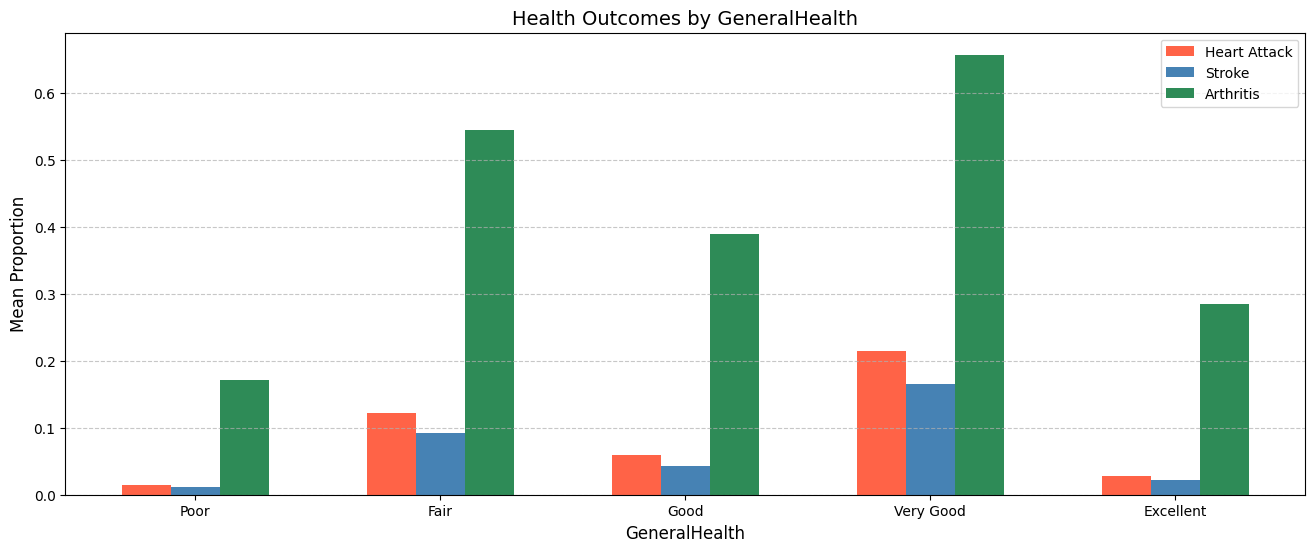

In [11]:
plot_bar('GeneralHealth', ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'], data_Q2)

- Từ biểu đồ chúng ta có thể thấy:
    + Mâu thuẫn giữa sức khỏe và tỷ lệ mắc bệnh: Những người có sức khỏe rất tốt lại có tỷ lệ mắc bệnh cao nhất, trong khi những người có sức khỏe rất kém lại có tỷ lệ mắc bệnh thấp nhất. Điều này có thể giải thích bởi việc phát hiện bệnh sớm ở những người sức khỏe tốt nhờ kiểm tra định kỳ, dẫn đến tỷ lệ mắc bệnh được ghi nhận cao hơn.
    + Mối quan hệ giữa sức khỏe và tỷ lệ mắc bệnh: Ở 3 nhóm còn lại thì tỷ lệ mắc bệnh giảm dần từ nhóm sức khỏe kém đến nhóm sức khỏe tốt và tuyệt vời. Điều này cho thấy việc duy trì sức khỏe tốt có thể giúp giảm nguy cơ mắc các bệnh mãn tính, nhấn mạnh tầm quan trọng của việc chăm sóc sức khỏe định kỳ và lối sống lành mạnh.

So sánh thời gian trung bình từ lần khám sức khỏe định kỳ gần nhất theo loại sức khỏe

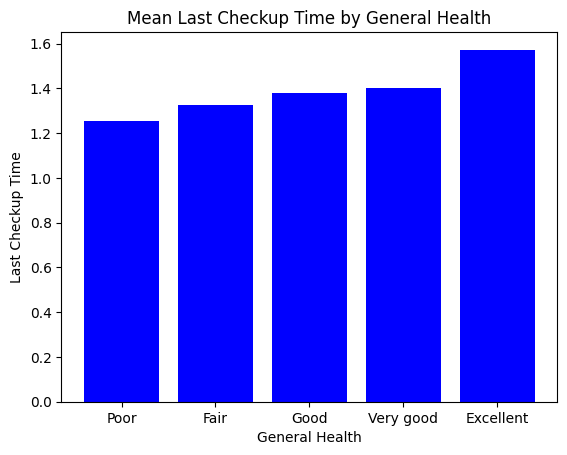

In [12]:
generalHealth = data_heart[['GeneralHealth', 'LastCheckupTime']].copy().reset_index(drop=True)

generalHealth.loc[generalHealth['LastCheckupTime'] == 'Within past year (anytime less than 12 months ago)', 'LastCheckupTime'] = 1
generalHealth.loc[generalHealth['LastCheckupTime'] == '5 or more years ago', 'LastCheckupTime'] = 6
generalHealth.loc[generalHealth['LastCheckupTime'] == 'Within past 2 years (1 year but less than 2 years ago)', 'LastCheckupTime'] = 1.5
generalHealth.loc[generalHealth['LastCheckupTime'] == 'Within past 5 years (2 years but less than 5 years ago)', 'LastCheckupTime'] = 3.5
generalHealth['GeneralHealth'] = pd.Categorical(
    generalHealth['GeneralHealth'], 
    categories=['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], 
    ordered=True
)
generalHealth = generalHealth.groupby('GeneralHealth',  observed=True).mean()

plt.bar(generalHealth.index, generalHealth['LastCheckupTime'], color='blue')
plt.xlabel('General Health')
plt.ylabel('Last Checkup Time')
plt.title('Mean Last Checkup Time by General Health')
plt.show()

+ Từ biểu đồ trên, lý do những người có sức khỏe rất tốt lại có tỷ lệ mắc bệnh cao nhất, trong khi những người có sức khỏe rất kém lại có tỷ lệ mắc bệnh thấp nhất, không phải do việc phát hiện bệnh sớm qua kiểm tra định kỳ. Thực tế, việc những người sức khỏe rất tốt có tỷ lệ mắc bệnh cao hơn có thể phản ánh rằng họ có các yếu tố nguy cơ khác (như di truyền, lối sống hoặc môi trường) mà không phải do phát hiện bệnh sớm. Ngược lại, những người có sức khỏe rất kém có thể không được kiểm tra đầy đủ hoặc không báo cáo các triệu chứng bệnh, dẫn đến tỷ lệ mắc bệnh thấp hơn, mặc dù có thể họ đang gặp các vấn đề sức khỏe nhưng chưa được ghi nhận.

##### 3.4.2 So sánh tỷ lệ mắc bệnh mãn tính giữa các nhóm của số ngày sức khỏe tinh thần không tốt

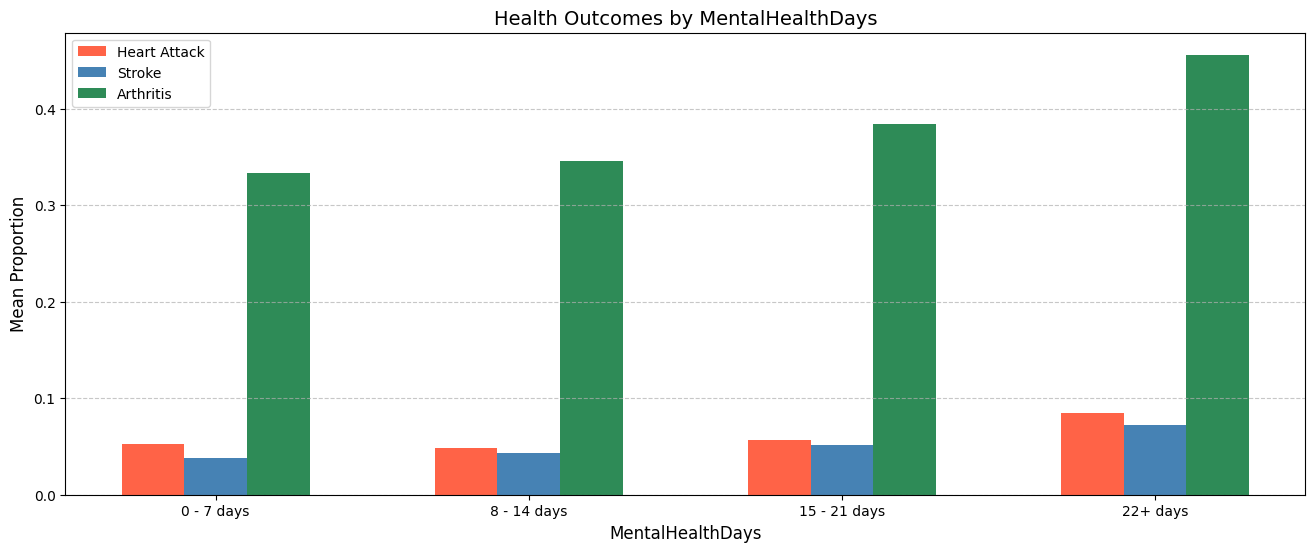

In [13]:
#plot_scatter_Q2('MentalHealthDays', data_Q2)

#Phân nhóm dựa theo MentalHealthDays
data_Q2.loc[(data_Q2['MentalHealthDays'] >= 0) & (data_Q2['MentalHealthDays'] <= 7), 'MentalHealthDays'] = 0 
data_Q2.loc[(data_Q2['MentalHealthDays'] > 7) & (data_Q2['MentalHealthDays'] <= 14), 'MentalHealthDays'] = 1
data_Q2.loc[(data_Q2['MentalHealthDays'] > 14) & (data_Q2['MentalHealthDays'] <= 21), 'MentalHealthDays'] = 2
data_Q2.loc[(data_Q2['MentalHealthDays'] > 21) & (data_Q2['MentalHealthDays'] <= 30), 'MentalHealthDays'] = 3

plot_bar('MentalHealthDays', ['0 - 7 days', '8 - 14 days', '15 - 21 days', '22+ days'], data_Q2)

Từ biểu đồ chúng ta có thể thấy
- Tương quan giữa sức khỏe tinh thần và tỷ lệ mắc bệnh: Số ngày sức khỏe tinh thần không tốt có mối tương quan thuận với tỷ lệ mắc các bệnh mãn tính. Đặc biệt, tỷ lệ mắc bệnh nhồi máu cơ tim có sự tương quan cao với số ngày sức khỏe tinh thần không tốt.
- Sự khác biệt giữa các nhóm: Nhóm người có số ngày sức khỏe tinh thần không tốt dưới 21 ngày có tỷ lệ mắc các bệnh mãn tính khá đồng đều, trong khi nhóm có số ngày sức khỏe tinh thần không tốt trên 22 ngày có tỷ lệ mắc các bệnh mãn tính cao rõ rệt. Điều này chỉ ra rằng sức khỏe tinh thần kém có thể làm tăng nguy cơ mắc các bệnh mãn tính.

##### 3.4.3 So sánh tỷ lệ mắc bệnh mãn tính giữa các nhóm của số ngày sức khỏe thể chất không tốt

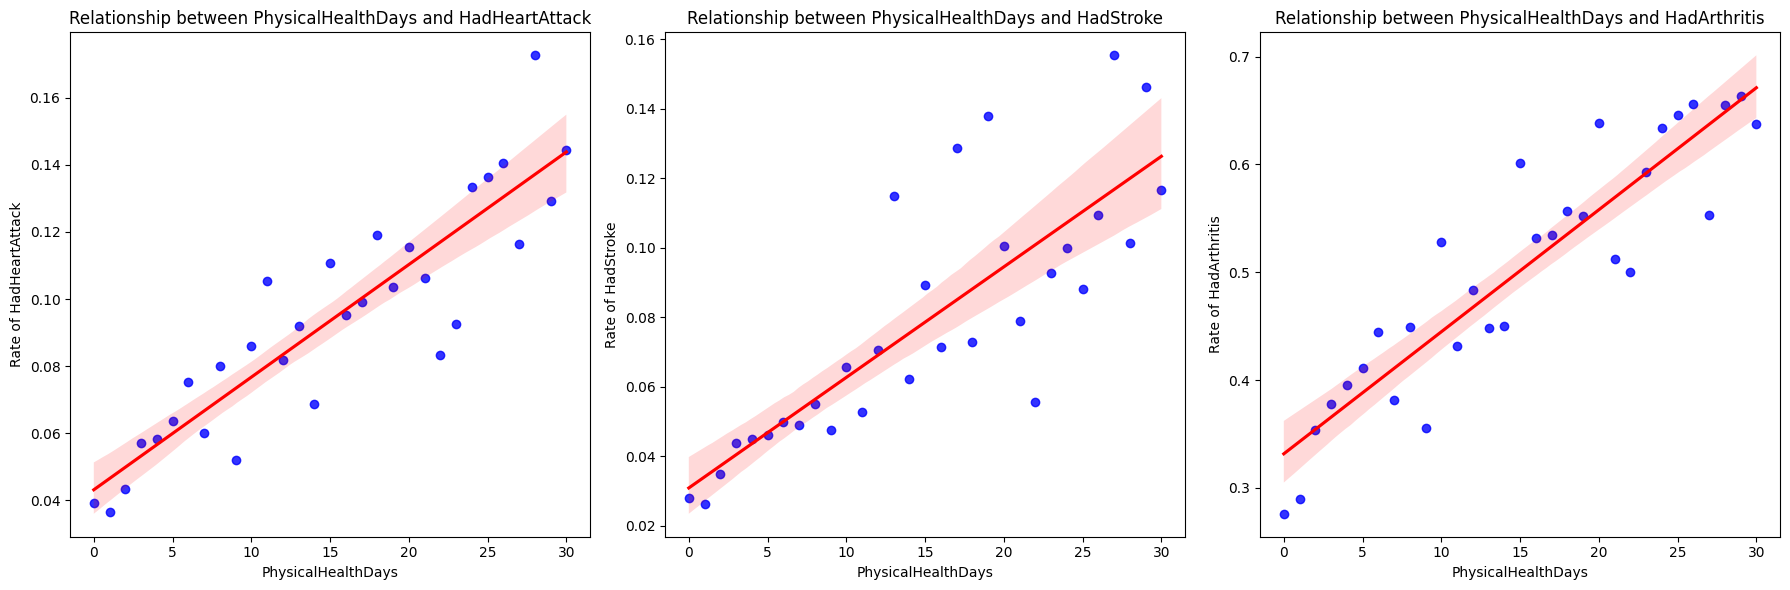

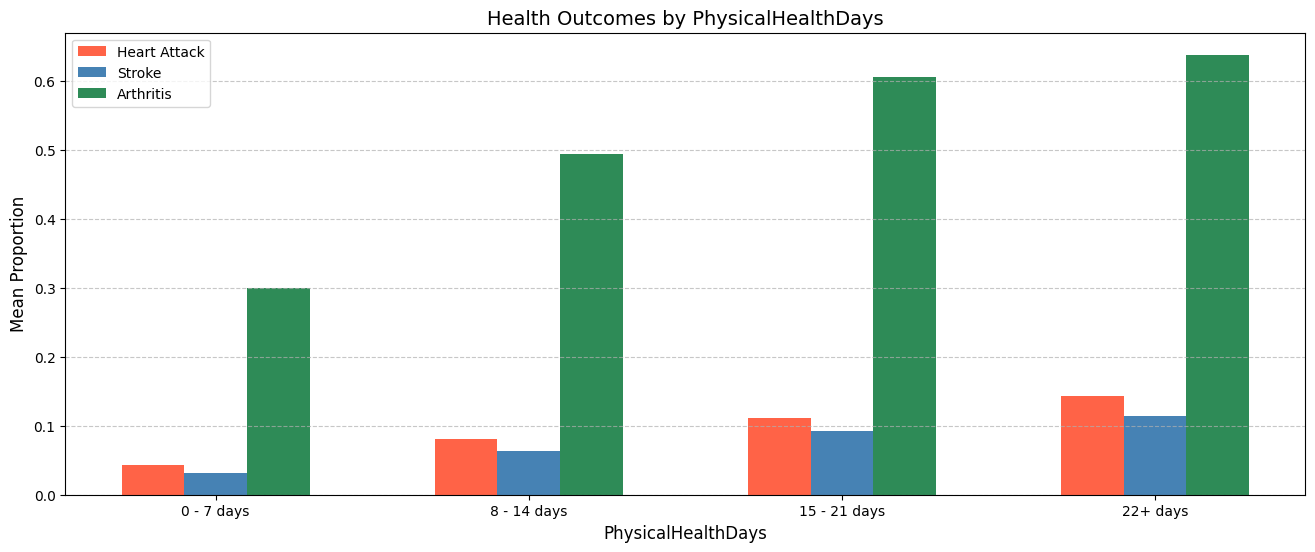

In [14]:
plot_scatter('PhysicalHealthDays', data_Q2)

#Phân nhóm dựa theo PhysicalHealthDays
data_Q2.loc[(data_Q2['PhysicalHealthDays'] >= 0) & (data_Q2['PhysicalHealthDays'] <= 7), 'PhysicalHealthDays'] = 0 
data_Q2.loc[(data_Q2['PhysicalHealthDays'] > 7) & (data_Q2['PhysicalHealthDays'] <= 14), 'PhysicalHealthDays'] = 1
data_Q2.loc[(data_Q2['PhysicalHealthDays'] > 14) & (data_Q2['PhysicalHealthDays'] <= 21), 'PhysicalHealthDays'] = 2
data_Q2.loc[(data_Q2['PhysicalHealthDays'] > 21) & (data_Q2['PhysicalHealthDays'] <= 30), 'PhysicalHealthDays'] = 3

#Biểu đồ so sánh tỉ lệ mắc bệnh giữa các nhóm của PhysicalHealthDays và tỷ lệ mắc bệnh
plot_bar('PhysicalHealthDays', ['0 - 7 days', '8 - 14 days', '15 - 21 days', '22+ days'], data_Q2)

Từ biểu đồ chúng ta có thể thấy
- Tương quan giữa sức khỏe thể chất và tỷ lệ mắc bệnh: Số ngày sức khỏe thể chất không tốt có mối tương quan thuận cao với tỷ lệ mắc các bệnh mãn tính.
- Sự thay đổi tỷ lệ mắc bệnh: Tỷ lệ mắc các bệnh mãn tính tăng rõ rệt khi số ngày sức khỏe thể chất không tốt cao. Điều này cho thấy rằng tình trạng sức khỏe thể chất kém có thể làm tăng nguy cơ mắc bệnh mãn tính.

##### 3.4.4 Trả lời câu hỏi

- Tình trạng sức khỏe thể chất và tinh thần có ảnh hưởng lớn đến tỷ lệ mắc các bệnh mãn tính. Sức khỏe thể chất kém và tinh thần không ổn định có thể là những yếu tố quan trọng làm tăng nguy cơ mắc bệnh mãn tính như nhồi máu cơ tim, đột quỵ và viêm khớp. Các chiến lược chăm sóc sức khỏe, bao gồm cả sức khỏe thể chất và tinh thần, là cần thiết để giảm thiểu nguy cơ mắc bệnh mãn tính và cải thiện chất lượng cuộc sống của người dân.